# Page Reading Analysis Project

## Stabilized Image Registration

### Step 1: Loading Data
* Load world.mp4 pupilpro video, high res image, segmented mask of high res image. (mount to drive if later)

### Step 2: Library management
* Downgrade OpenCV (to be able to use SIFT) and restart kernel


In [38]:
# #Comment it after doing it once
# !pip uninstall opencv-python
# !pip uninstall opencv-contrib-python
# !pip install opencv-python==3.4.2.16
# !pip install opencv-contrib-python==3.4.2.16

In [39]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import math
import imageio
import tqdm
import pandas as pd
%matplotlib inline

### Step 4: Feature Detection and Matching
* Feature Detection using SIFT
* Feature Matching using Brute Force Matcher (K nearest neighbors)

In [40]:
# Feature detection using SIFT
def get_features(img):
  '''Detect and compute interest points and their descriptors
  using SIFT detector for an image
  :param: img - frame read from folder
  :type: numpy arrayG
  '''
  sift = cv2.xfeatures2d.SIFT_create()
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  kp, des = sift.detectAndCompute(img, None)
  return img, kp, des

In [41]:
# Feature matching using BFMatcher and visualizing results
def draw_image_matches(img1, img2, plot = False):
  ''' This function uses a Brute Force matcher to match the features obtained in
  both images and returns the matched feature sets.
  :param: detector - type of OpenCV detector to be used,
  im1_name - name of frame 1 in folder, img2_name - name of frame 2 in folder,
  flag - indicates whether combined new features have to be obtained
  :type: detector object, string, string
  '''
  img1, kp1, des1 = get_features(img1)
  img2, kp2, des2 = get_features(img2)
  bf = cv2.BFMatcher() #Try Flann later
  matches = bf.knnMatch(des1,des2,k=2)

  if plot == True:
      img_matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=2)
      plt.figure(figsize=(16, 16))
      plt.title("Matched features (without Outlier rejection)")
      plt.imshow(img_matches)
      plt.show()      
  return img1, kp1, img2, kp2, matches

### Step 5: Reading frames and rectification
* Undistort distortion introduced by camera (only if fisheye distortion option was off while recording video)
* Read first frame and undistort if necessary
* ** Specify propogation length
* **Create a list holding propogation_length number of images
* Resize high resolution image to size of first frame of video


In [42]:
distortion = 1 #flag indicating if fisheye was on or off

camera_matrix = np.array([[829.3510515270362, 0.0, 659.9293047259697], [0.0, 799.5709408845464, 373.0776462356668], [0.0, 0.0, 1.0]])
dist_coefs = np.array([[-0.43738542863224966, 0.190570781428104, -0.00125233833830639, 0.0018723428760170056, -0.039219091259637684]])
vidcap = cv2.VideoCapture('C:\\Users\\18587\\Desktop\\world.mp4')

fps = vidcap.get(cv2.CAP_PROP_FPS)
success,image = vidcap.read()
if distortion == 1:
  image = cv2.undistort(image, camera_matrix, dist_coefs) #removing distortion
source_img = cv2.cvtColor(cv2.imread('C:\\Users\\18587\\Desktop\\high.jpg'), cv2.COLOR_BGR2RGB)
source_img = cv2.resize(source_img, (image.shape[1], image.shape[0]))

### Step 6: Visualization
* Display the high res image and first frame side by side.
* This is done to ensure two things:
  * Firstly, the video has been uploaded correctly
  * Secondly, the high res image you are mapping to the frame is from the same page.

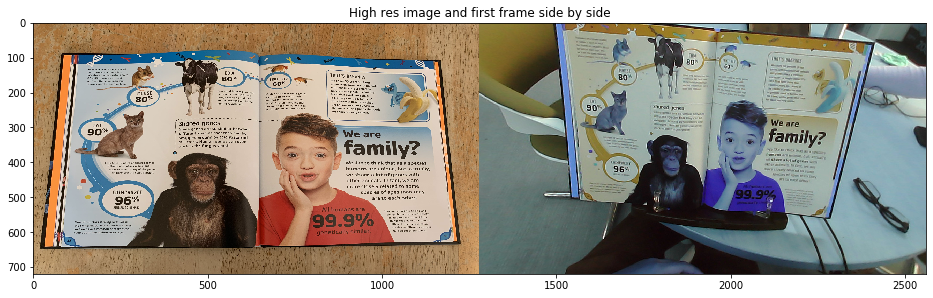

In [43]:
both_original = np.hstack((source_img, image))
plt.figure(figsize=(16, 16))
plt.title("High res image and first frame side by side")
plt.imshow(both_original)
plt.show()

### Step 7: Visualization
* Now look at the matches. The matches should be extremely concentrated near the book region.
* Also check how many matches were obtained.

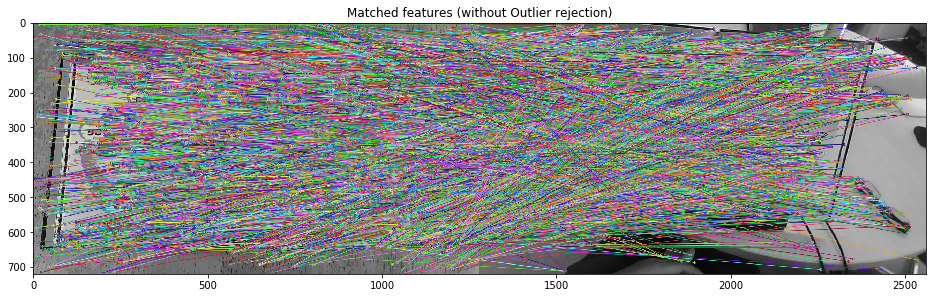

Number of feature matches obtained is:7074


In [44]:
img1, kp1, img2, kp2, matches = draw_image_matches(source_img, image, plot = True)
matches_list = [item for sublist in matches for item in sublist]
print("Number of feature matches obtained is: ", len(matches_list))

* As you can see, the matches are not well distributed. This is because the right side of the page is unreadable to the machine. We can expect some distortion in this case.

### Step 8: Outlier Rejection
* Reject the outliers. Outliers are matches that dont make sense at all.
* Outlier rejection is usually done in two steps:
  * Distance ratio (Lowe's ratio)
  * RANSAC
* Both of these are performed here to reject outliers

In [45]:
def reject_outliers(img1, kp1, img2, kp2, matches, plot = False, outliers = False, lowe_ratio = 0.70, ransac_reproj = 5.0):
    ''' This function rejects the outliers using RANSAC and returns the inlier features
    corresponding to frames
    :param: matches - matched distances found using brute force matcher,
    MIN_MATCH_COUNT - minimum number of matches that have to be there
    :type: list of match objects, int
    '''
    # store all the good matches based on distance
    good_2 = []
    # Choosing matching features based on Lowe's distance
    for m,n in matches:
        if m.distance < lowe_ratio* n.distance:
            good_2.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_2 ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_2 ]).reshape(-1,1,2)
    _, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_reproj)
    inlier_mask = [i for i, x in enumerate(mask) if x == 1]
    outlier_mask = [i for i, x in enumerate(mask) if x == 0]
    good_matches = [[good_2[i]] for i in inlier_mask]
    bad_matches = [[good_2[i]] for i in outlier_mask]
    good_matches_2 = [good_2[i] for i in inlier_mask]
    # good matches and good matches 2 are the same except their representation
    if plot == True:
        img_inliers = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        plt.figure(figsize=(16, 16))
        plt.title("Matched features after Outlier rejection")
        plt.imshow(img_inliers)
        plt.show()
  
    if outliers == True:
        return good_matches,good_matches_2, bad_matches
    return good_matches, good_matches_2

### Step 9: Visualization
* Visualize the outlier rejected matches.
* Good matches will show only one to one correspondence and will always be parallel to each other.
* Counting the number of good matches.

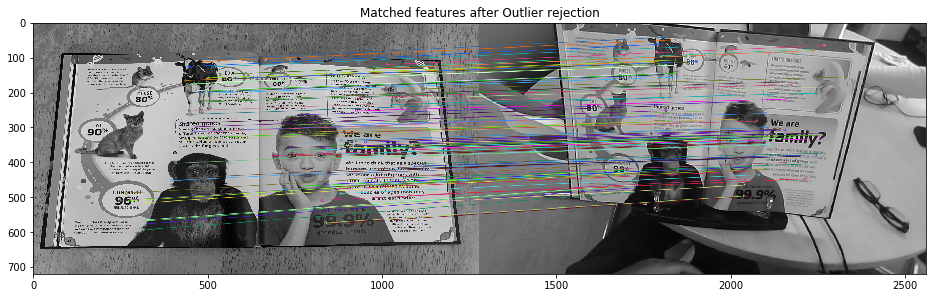

In [46]:
good_matches,_ = reject_outliers(img1, kp1, img2, kp2, matches, plot = True)

* As you can see, all matches obtained in this case are good, but there are no matches in the right side of the page. This is going to be a problem

* Results on using a different reprojection error threshold is shown below. (Larger value indicates less penalty on outliers. Hence, larger the value of reprojection error, more matches can be obtained but they could contain outliers too).

In [47]:
good_matches,_ = reject_outliers(img1, kp1, img2, kp2, matches, plot = True, ransac_reproj=20.0) #ransac_reproj = 5.0 gives bad mapping

* Counting matches (if more than 100, take only first 100 matches)

In [48]:
matches_list = [item for sublist in good_matches for item in sublist]
print("Number of putative features matched is: ", len(matches_list))

Number of putative features matched is:152


### Step 10: Homography estimation
* Finding Homographic transform that maps the high res image to the frame of the video.
* Remember, if the transformation of source image to target image does not hold general shape (vertices direction), determinant of the homography will be near 0.
* A second layer of protection is done through parameter sweep.
* If no good homographic transformations are obtained, just skip the frame.

In [49]:
def find_homography(img_dst, img_src, plot = False, bad_homography = False):
  ''' This function finds the 2D projective transform between two frames
  which maps frame img_src to img_dst
  :param: img_src - source image,
  img_dst - destination image,
  ''' 
  if bad_homography == True:
    # img1 gets transformed to img2
    img1, kp1, img2, kp2, matches = draw_image_matches(img_src, img_dst)
    for lowe in [0.70, 0.75]:
      for reproj_err in [1.0, 5.0, 10.0, 20.0]:
        good_matches1,good_matches = reject_outliers(img1, kp1, img2, kp2, matches, lowe_ratio=lowe, ransac_reproj=reproj_err)      
        #src means source
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        #dst means destination
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        transform, _ = cv2.findHomography(src_pts, dst_pts)
        if type(transform) != 'numpy.ndarray':
          continue
        if 0.1 < np.linalg.det(transform) < 1:
          break

  #if transform is good...go on...
  # img1 gets transformed to img2
  elif bad_homography == False:
    img1, kp1, img2, kp2, matches = draw_image_matches(img_src, img_dst)
    good_matches1,good_matches = reject_outliers(img1, kp1, img2, kp2, matches)      
    #src means source
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    #dst means destination
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    transform, _ = cv2.findHomography(src_pts, dst_pts)

  h,w = img2.shape[:2]
  size = (w,h)
  img_transformed = cv2.warpPerspective(img1, transform, size)
  if plot == True:
    both = np.hstack((img1, img2, img_transformed))
    plt.figure(figsize=(16, 16))
    plt.title("Source Image                                                  Destination Image                                                 Transformed Image")
    plt.imshow(both, cmap = 'gray')
    plt.grid()
    plt.show()
  return transform

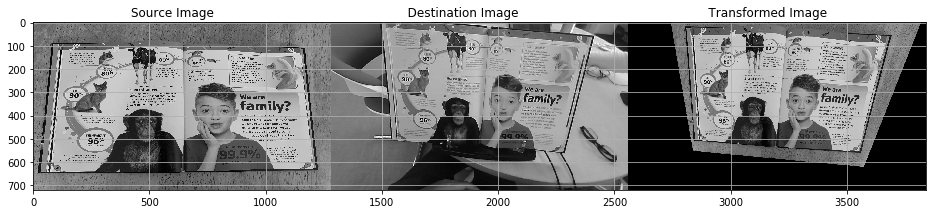

In [50]:
H  = find_homography(image, source_img, plot = True, bad_homography = False)

### Step 11: Segment preprocessing
* Video initialization
* Segmentation mask processing
* Annotation of segmentation

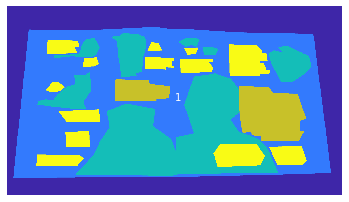

In [51]:
fps = vidcap.get(cv2.CAP_PROP_FPS)
w,h = image.shape[1], image.shape[0]
size = (w,h)
video1 = cv2.VideoWriter('C:\\Users\\18587\\Desktop\\trialfinal.mp4', 0, fps, (w,h))
video2 = cv2.VideoWriter('C:\\Users\\18587\\Desktop\\trialfinaloverlap.mp4', 0, fps, (w,h))
#video3 = cv2.VideoWriter('C:\\Users\\18587\\Desktop\\Image Registration\\trialfinaloverlap_cca.mp4', 0, fps, (w,h))
segment =  cv2.cvtColor(cv2.imread('C:\\Users\\18587\\Desktop\\seg.png'), cv2.COLOR_BGR2RGB)
segment = cv2.resize(segment, (size))
plt.imshow(segment)
cca_img = np.array(cv2.cvtColor(segment, cv2.COLOR_RGB2GRAY))
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cca_img, connectivity=8)
for i in range(1,nb_components):
  plt.annotate(str(i), centroids[i], fontsize = 10, color = (1,1,1))
plt.axis('off')
plt.savefig('label_with_cca.jpg',bbox_inches='tight',pad_inches=0) # saving for fun...
plt.show()
segment_cca = cv2.cvtColor(cv2.imread('label_with_cca.jpg'), cv2.COLOR_BGR2RGB)
# print(segment_cca.shape)
segment_cca = cv2.resize(segment_cca, (size))
# print(segment_cca.shape)

### Step 12: Looping through entire video
* Once everything is set up, perform homography estimation for all frames of the video.
* While performing homographies, also store angle, scaling, shear and skipped frames.

In [52]:
count = 0
skipped = []
all_homographies = []
angles = []
translations = []
scales = []
shears = []
while success:
  try:
    H = find_homography(image, source_img)
  except:
    skipped.append(count)
    success,image = vidcap.read()
    count += 1
    continue
  all_homographies.append(H)
  u, _, vh = np.linalg.svd(H[0:2, 0:2])
  R = u @ vh
  angle = math.atan2(R[1,0], R[0,0]) * 180 / np.pi
  angles.append(angle)
  t_x, t_y = H[0,2], H[1,2]
  translations.append((t_x, t_y))
  scale_A, scale_B = (H[0,0], H[1,1])
  scales.append((scale_A,scale_B))
  shear_x, shear_y = H[0,1], H[1,0]
  shears.append((shear_x,shear_y))
  if (np.isclose(np.linalg.det(H),0,atol=1e-1)):
    all_homographies.pop()
    angles.pop()
    translations.pop()
    scales.pop()
    shears.pop()
    H = find_homography(image, source_img, bad_homography=True)
    all_homographies.append(H)
    u, _, vh = np.linalg.svd(H[0:2, 0:2])
    R = u @ vh
    angle = math.atan2(R[1,0], R[0,0]) * 180 / np.pi
    angles.append(angle)
    t_x, t_y = H[0,2], H[1,2]
    translations.append((t_x, t_y))
    scale_A, scale_B = (H[0,0], H[1,1])
    scales.append((scale_A,scale_B))
    shear_x, shear_y = H[0,1], H[1,0]
    shears.append((shear_x,shear_y))
  if (np.isclose(np.linalg.det(H),0,atol=1e-1)): # if transform is bad even after parameter sweep, skip it
    all_homographies.pop()
    angles.pop()
    translations.pop()
    scales.pop()
    shears.pop()
    success,image = vidcap.read()
    if distortion:
      image = cv2.undistort(image, camera_matrix, dist_coefs) #removing distortion
    skipped.append(count)
    continue 
  transformed_seg1 = cv2.warpPerspective(segment, H, size)
  video1.write(transformed_seg1)
  overlap1 = cv2.addWeighted(image,0.5,transformed_seg1,0.5,0)
  video2.write(overlap1)
  #transformed_seg2 = cv2.warpPerspective(segment_cca, H, size)
  #overlap2 = cv2.addWeighted(image,0.5,transformed_seg2,0.5,0)
  #video3.write(overlap2)
  success,image = vidcap.read()
  if not success:
    break
  if distortion:
    image = cv2.undistort(image, camera_matrix, dist_coefs) #removing distortion
  count += 1
  if count % 100 == 0:
    print (count)
cv2.destroyAllWindows()
video1.release()
video2.release()
#video3.release()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


### Step 13: Compression
* Compress the videos obtained.
* The original videos will be of the order of 10s of GBs. Run the command below to reduce them to less than 100 Mb.

In [53]:
# !ffmpeg -i trialfinaloverlap.mp4 -vcodec h264 -acodec mp2 prot2_overlap.mp4
# !ffmpeg -i trialfinal.mp4 -vcodec h264 -acodec mp2 prot2_segmented.mp4

### Step 14: Logging data
* Log all the data onto a csv file

In [54]:
import pandas as pd
df = pd.DataFrame()
df['Homographies'] = all_homographies
df['Anglular Change'] = angles
df['Translations'] = translations
df['Scaling Factor'] = scales
df['Shear Factor'] = shears
length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
indices = list(set([*range(count + len(set(skipped)) + 1)]) - set(skipped))
# len(indices)
df['frame'] = indices
df.set_index('frame', inplace=True)
# df.loc['Mean values'] = df.mean()
# df.loc['Variance'] = df.var()
# df.loc['Median values'] = df.median()
df.head()

Homographies  Anglular Change  \
frame                                                                       
0      [[0.7330951164937698, 0.3417008793811102, 165....        -9.486081   
1      [[0.8422220725443428, 0.4353024179685639, 116....        -9.978661   
2      [[0.7379627157429927, 0.3400362568026514, 169....        -9.259376   
3      [[0.8267021597030075, 0.4277396535914791, 129....        -9.907781   
4      [[0.8108624639020037, 0.41368478784922513, 135...        -9.678185   

                                    Translations  \
frame                                              
0       (165.94157216923452, -94.44025571925195)   
1        (116.55844357906037, -142.048298700881)   
2      (169.22349832154663, -101.10522311003737)   
3       (129.22729300695252, -141.7289982002098)   
4       (135.8430525798421, -140.33210685311428)   

                                 Scaling Factor  \
frame                                             
0      (0.7330951164937698, 1.2686517915447224)   
1      (0.8422220725443428, 1.3974970007259526)   
2      (0.7379627157429927, 1.2766878277039815)   
3       (0.8267021597030075, 1.394234814783948)   
4      (0.8108624639020037, 1.3776613651677063)   

                                     Shear Factor  
frame                                              
0      (0.3417008793811102, 0.007223201464673602)  
1       (0.4353024179685639, 0.04123953975972894)  
2       (0.3400362568026514, 0.01159116126075333)  
3      (0.4277396535914791, 0.039813309125565514)  
4      (0.41368478784922513, 0.04045113272385747)

In [55]:
df.to_csv('C:\\Users\\18587\\Desktop\\prot2.csv')

### Last Step: Keep adding here...
* Download everything necessary.
* I'd recommend processing the videos in this notebook itself. The pipeline of downloading and reuploading is very time consuming.